## Preamble



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
import pandas as pd
import numpy as np
from getdist import plots, MCSamples
from IPython.display import HTML, display
import tabulate

## Plot cosmological parameters distribution



### Cosmo. parameters LaTeX labels



In [1]:
labels = [r"$\theta_\mathrm{MC}$",
          r"$A_\mathrm{s}$",
          r"$n_\mathrm{s}$",
          r"$\Omega_\mathrm{b}h^2$",
          r"$\Omega_\mathrm{c}h^2$",
          r"$\chi^2-\chi^2_\mathrm{min}$"]

### Get cosmo. parameters from output file



In [1]:
def get_params(path, pattern="*.likelihood", weight=False):
    import os, glob
    all_files = glob.glob(os.path.join(path, pattern))
    # Sort alphabetically
    all_files.sort()

    header = pd.read_csv(all_files[0], delim_whitespace=True).columns[1:]
    df = pd.concat((pd.read_table(f, delim_whitespace=True) for f in all_files))

    # Remove '#' in header
    df.drop(df.columns[[-1,]], axis=1, inplace=True)
    df.columns = header
    # Compute delta chi2
    delta_chi2 = df.chi2-np.min(df.chi2)
    # Remove useless columns
    df.drop(columns=["weight", "minuslogpost", "minuslogprior", "minuslogprior__0", "chi2", "chi2__chi2"], inplace=True)
    # Insert Delta chi2 before As (which is derived and never plot)
    df.insert(value=delta_chi2, column="delta_chi2", loc=len(df.columns))

    params = np.array(df)
    return params

### Show input values of cosmo. parameters



In [1]:
ref = [1.04164/100, np.exp(3.058)/1e10, 0.9649, 0.02212, 0.1210]
def show_ref(g):
    for i, r in enumerate(ref):
        kwargs = dict(color="gray", ls="--", lw=1)
        for ax in g.subplots[:,i]:
            if ax: ax.axvline(r, **kwargs)
        for ax in g.subplots[i,:i]:
            if ax: ax.axhline(r, **kwargs)

### Results from pure Planck simulation



#### Cosmo. parameters distribution



In [1]:
params = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/unbinned")
samples = MCSamples(samples=params, names=labels)

# Out[839]:

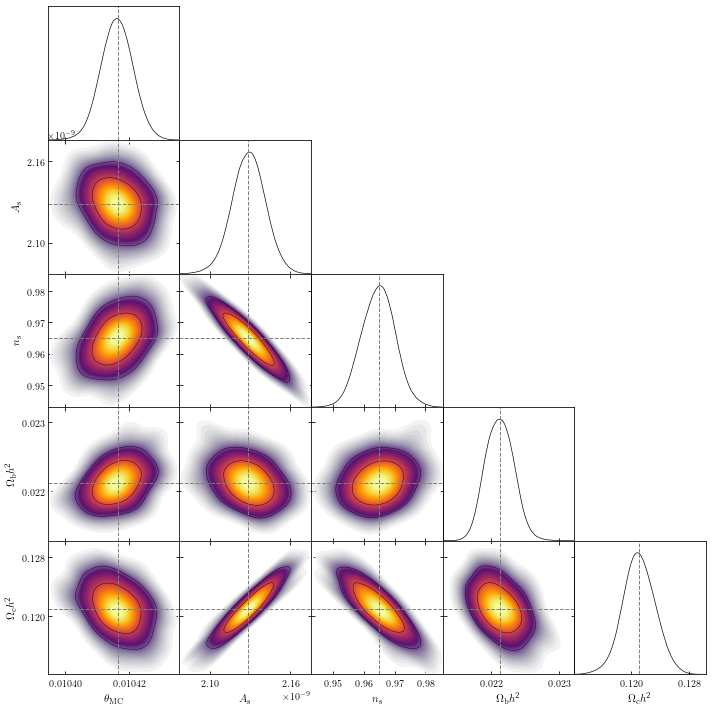

In [1]:
g = plots.getSubplotPlotter()
g.settings.colormap = "inferno"
g.triangle_plot(samples, params=labels[:-1], shaded=True)
show_ref(g)

# Out[840]:

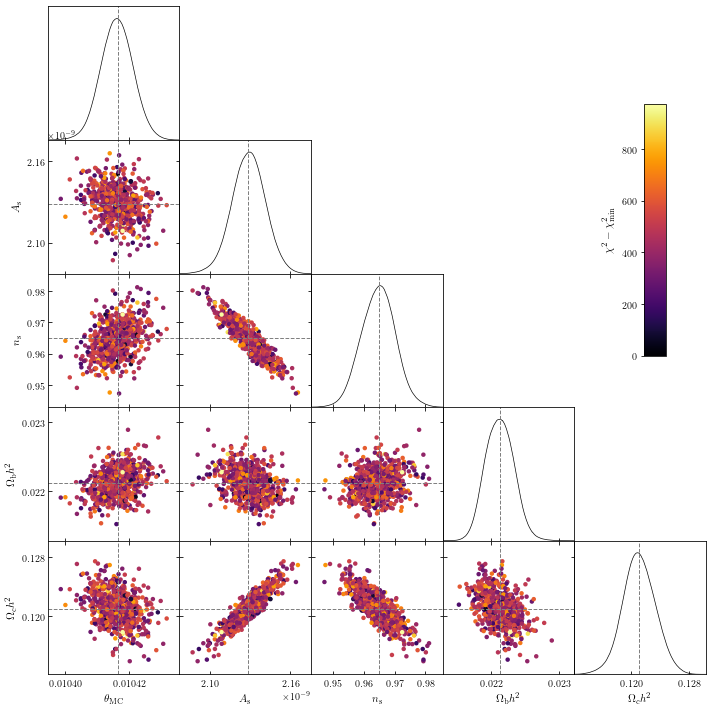

In [1]:
g = plots.getSubplotPlotter()
g.settings.colormap_scatter = "inferno"
g.triangle_plot(samples, params=labels[:-1],
                plot_3d_with_param="$\chi^2-\chi^2_\mathrm{min}$", scatter_size=20)
show_ref(g)

In [1]:
print("Number of sucessful minimization :", np.alen(params))

Number of sucessful minimization : 638

In [1]:
min_mean = np.mean(params, axis=0)
min_std  = np.std(params, axis=0)
fisher = np.array([5.1265507267143515e-06, 1.2854648947626772e-11, 0.005589724100405197, 0.00020382255228959767, 0.002334040314343261, 1.])
lines = [[r"$\mu$"], [r"$\sigma$"], [r"$\sigma$ (Fisher)"], [r"$\Delta\sigma$ (min-Fisher) [%]"]]
table = np.stack([min_mean, min_std, fisher, 100*(min_std-fisher)/fisher])
table = np.append(lines, table, axis=1)

In [1]:
display(HTML(tabulate.tabulate(table, headers=labels, tablefmt="html")))

# Out[17]:
<IPython.core.display.HTML object>

## Simons Observatory ⊗ Planck



### \ell \in [2; 3000]



In [1]:
params_SO   = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_2_3000", "*SO.likelihood")
params_SOxP = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_2_3000", "*SOxP.likelihood")
params_P    = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_2_3000", "*_P.likelihood")
params_SO.shape, params_SOxP.shape, params_P.shape

# Out[844]:
((978, 6), (978, 6), (978, 6))

In [1]:
samples_SO   = MCSamples(samples=params_SO, names=labels, label="SOxSO")
samples_SOxP = MCSamples(samples=params_SOxP, names=labels, label="SOxP")
samples_P    = MCSamples(samples=params_P, names=labels, label="PxP")

In [1]:
lines = [[r"$\mu$(SOxSO)"], [r"$\mu$(SOxP)"], [r"$\mu$(PxP)"],
         [r"$\sigma$(SOxSO)"], [r"$\sigma$(SOxP)"], [r"$\sigma$(PxP)"],
         [r"$\sigma$(SOxSO - PxP)"], [r"$\sigma$(SOxSO - SOxP)"], [r"$\sigma$(SOxSO + PxP - 2 SOxP)"]]
std_SO, std_SOxP, std_P = np.std(params_SO, axis=0), np.std(params_SOxP, axis=0), np.std(params_P, axis=0)
std_SOmP = np.std(params_SO-params_P, axis=0)
std_SOmSOxP = np.std(params_SO-params_SOxP, axis=0)
std_SOpPm2SOxP = np.std(params_SO + params_P - 2*params_SOxP, axis=0)
table = np.stack([np.mean(params_SO, axis=0),
                  np.mean(params_SOxP, axis=0),
                  np.mean(params_P, axis=0),
                  std_SO, std_SOxP, std_P,
                  std_SOmP, std_SOmSOxP, std_SOpPm2SOxP
])
table = np.append(lines, table, axis=1)
display(HTML(tabulate.tabulate(table, headers=labels, tablefmt="html")))

Set PxP deviation as standard for further comparison



In [1]:
ref_std = std_P

# Out[848]:

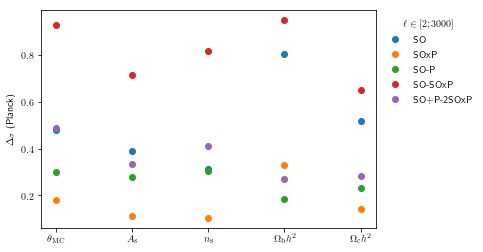

In [1]:
x = np.arange(5)
plt.plot(x, (ref_std/std_SO-1)[:-1], "o", label="SO")
plt.plot(x, (ref_std/std_SOxP-1)[:-1], "o", label="SOxP")
plt.plot(x, (ref_std/std_SOmP-1)[:-1], "o", label="SO-P")
plt.plot(x, (ref_std/std_SOmSOxP-1)[:-1], "o", label="SO-SOxP")
plt.plot(x, (ref_std/std_SOpPm2SOxP-1)[:-1], "o", label="SO+P-2SOxP")
plt.xticks(x, labels[:-1])
plt.ylabel(r"$\Delta_\sigma$ (Planck)")
plt.legend(loc="upper left", title=r"$\ell\in[2; 3000]$", bbox_to_anchor=(1,1))

### \ell \in [50; 2000]



In [1]:
params_SO   = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_50_2000", "*SO.likelihood")
params_SOxP = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_50_2000", "*SOxP.likelihood")
params_P    = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_50_2000", "*_P.likelihood")
params_SO.shape, params_SOxP.shape, params_P.shape

# Out[232]:
((971, 6), (971, 6), (971, 6))

In [1]:
samples_SO   = MCSamples(samples=params_SO, names=labels, label="SOxSO")
samples_SOxP = MCSamples(samples=params_SOxP, names=labels, label="SOxP")
samples_P    = MCSamples(samples=params_P, names=labels, label="PxP")

# Out[178]:

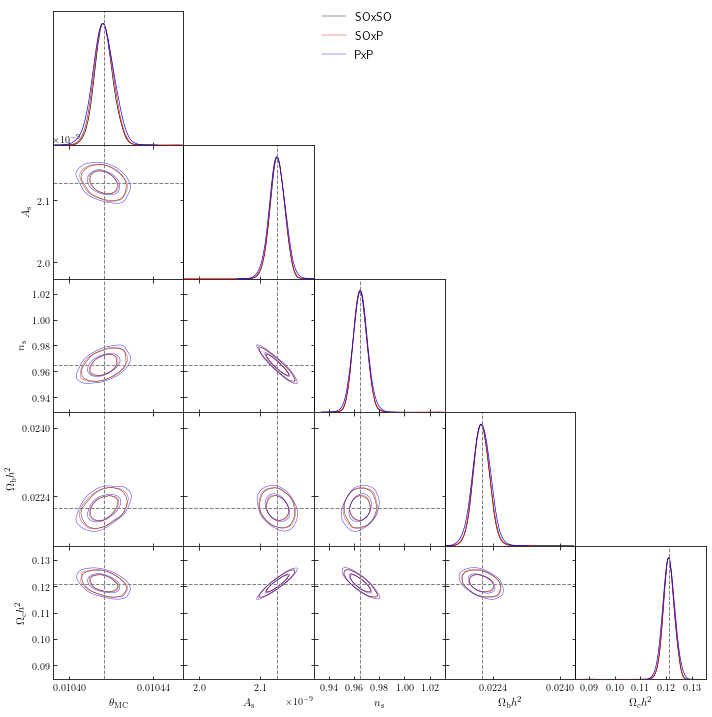

In [1]:
g = plots.getSubplotPlotter()
g.triangle_plot([samples_SO, samples_SOxP, samples_P], params=labels[:-1])
show_ref(g)

In [1]:
lines = [[r"$\mu$(SOxSO)"], [r"$\mu$(SOxP)"], [r"$\mu$(PxP)"],
         [r"$\sigma$(SOxSO)"], [r"$\sigma$(SOxP)"], [r"$\sigma$(PxP)"],
         [r"$\sigma$(SOxSO - PxP)"], [r"$\sigma$(SOxSO - SOxP)"], [r"$\sigma$(SOxSO + PxP - 2 SOxP)"]]
std_SO, std_SOxP, std_P = np.std(params_SO, axis=0), np.std(params_SOxP, axis=0), np.std(params_P, axis=0)
std_SOmP = np.std(params_SO-params_P, axis=0)
std_SOmSOxP = np.std(params_SO-params_SOxP, axis=0)
std_SOpPm2SOxP = np.std(params_SO + params_P - 2*params_SOxP, axis=0)
table = np.stack([np.mean(params_SO, axis=0),
                  np.mean(params_SOxP, axis=0),
                  np.mean(params_P, axis=0),
                  std_SO, std_SOxP, std_P,
                  std_SOmP, std_SOmSOxP, std_SOpPm2SOxP
])
table = np.append(lines, table, axis=1)
display(HTML(tabulate.tabulate(table, headers=labels, tablefmt="html")))

# Out[234]:

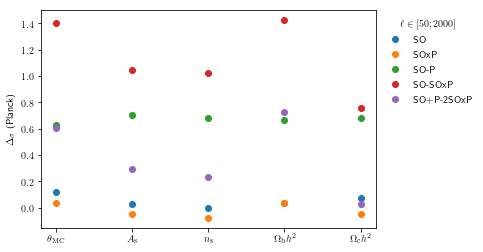

In [1]:
x = np.arange(5)
plt.plot(x, (ref_std/std_SO-1)[:-1], "o", label="SO")
plt.plot(x, (ref_std/std_SOxP-1)[:-1], "o", label="SOxP")
plt.plot(x, (ref_std/std_SOmP-1)[:-1], "o", label="SO-P")
plt.plot(x, (ref_std/std_SOmSOxP-1)[:-1], "o", label="SO-SOxP")
plt.plot(x, (ref_std/std_SOpPm2SOxP-1)[:-1], "o", label="SO+P-2SOxP")
plt.xticks(x, labels[:-1])
plt.ylabel(r"$\Delta_\sigma$ (Planck)")
plt.legend(loc="upper left", title=r"$\ell\in[50; 2000]$", bbox_to_anchor=(1,1))

### \ell \in [50; 1500]



In [1]:
params_SO   = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_50_1500", "*SO.likelihood")
params_SOxP = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_50_1500", "*SOxP.likelihood")
params_P    = get_params(r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ell_50_1500", "*_P.likelihood")
params_SO.shape, params_SOxP.shape, params_P.shape

# Out[237]:
((1001, 6), (1001, 6), (1001, 6))

In [1]:
samples_SO   = MCSamples(samples=params_SO, names=labels, label="SOxSO")
samples_SOxP = MCSamples(samples=params_SOxP, names=labels, label="SOxP")
samples_P    = MCSamples(samples=params_P, names=labels, label="PxP")

# Out[206]:

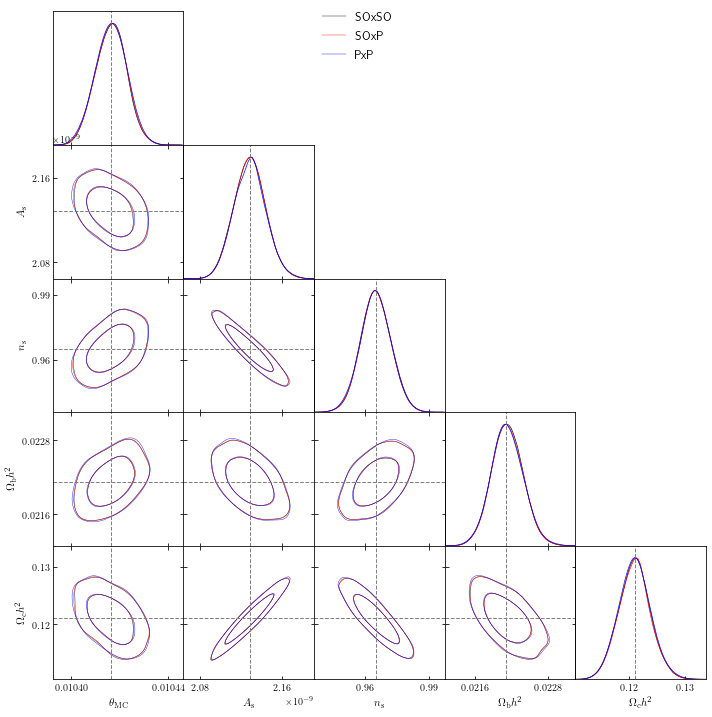

In [1]:
g = plots.getSubplotPlotter()
g.triangle_plot([samples_SO, samples_SOxP, samples_P], params=labels[:-1])
show_ref(g)

In [1]:
lines = [[r"$\mu$(SOxSO)"], [r"$\mu$(SOxP)"], [r"$\mu$(PxP)"],
         [r"$\sigma$(SOxSO)"], [r"$\sigma$(SOxP)"], [r"$\sigma$(PxP)"],
         [r"$\sigma$(SOxSO - PxP)"], [r"$\sigma$(SOxSO - SOxP)"], [r"$\sigma$(SOxSO + PxP - 2 SOxP)"]]
std_SO, std_SOxP, std_P = np.std(params_SO, axis=0), np.std(params_SOxP, axis=0), np.std(params_P, axis=0)
std_SOmP = np.std(params_SO-params_P, axis=0)
std_SOmSOxP = np.std(params_SO-params_SOxP, axis=0)
std_SOpPm2SOxP = np.std(params_SO + params_P - 2*params_SOxP, axis=0)
table = np.stack([np.mean(params_SO, axis=0),
                  np.mean(params_SOxP, axis=0),
                  np.mean(params_P, axis=0),
                  std_SO, std_SOxP, std_P,
                  std_SOmP, std_SOmSOxP, std_SOpPm2SOxP
])
table = np.append(lines, table, axis=1)
display(HTML(tabulate.tabulate(table, headers=labels, tablefmt="html")))

# Out[239]:

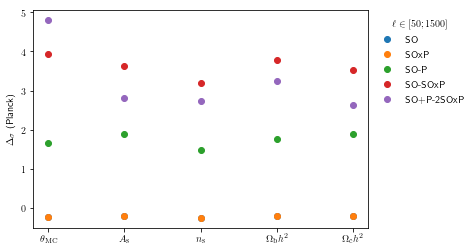

In [1]:
x = np.arange(5)
plt.plot(x, (ref_std/std_SO-1)[:-1], "o", label="SO")
plt.plot(x, (ref_std/std_SOxP-1)[:-1], "o", label="SOxP")
plt.plot(x, (ref_std/std_SOmP-1)[:-1], "o", label="SO-P")
plt.plot(x, (ref_std/std_SOmSOxP-1)[:-1], "o", label="SO-SOxP")
plt.plot(x, (ref_std/std_SOpPm2SOxP-1)[:-1], "o", label="SO+P-2SOxP")
plt.xticks(x, labels[:-1])
plt.ylabel(r"$\Delta_\sigma$ (Planck)")
plt.legend(loc="upper left", title=r"$\ell\in[50; 1500]$", bbox_to_anchor=(1,1))

## MCMC analysis



### Check chains



In [1]:
labels = [r"$\theta_\mathrm{MC}$",
          r"$\log(10^{10}A_\mathrm{s})$",
          r"$n_\mathrm{s}$",
          r"$\Omega_\mathrm{b}h^2$",
          r"$\Omega_\mathrm{c}h^2$",
          r"$\chi^2-\chi^2_\mathrm{min}$",
          r"$A_\mathrm{s}$"]

result_path=r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/mcmc"

In [1]:
def get_chains(path):
    import glob
    all_files = glob.glob(path)
    # Sort alphabetically
    all_files.sort()
    chains = {}
    for f in all_files:
        header = pd.read_csv(all_files[0], delim_whitespace=True).columns[1:]
        df = pd.read_table(f, delim_whitespace=True)

        # Remove '#' in header
        df.drop(df.columns[[-1,]], axis=1, inplace=True)
        df.columns = header
        # Compute delta chi2
        delta_chi2 = df.chi2-np.min(df.chi2)
        # Remove useless columns
        df.drop(columns=["minuslogpost", "minuslogprior", "minuslogprior__0", "chi2", "chi2__chi2"], inplace=True)
        # Insert Delta chi2 before As (which is derived and never plot)
        df.insert(value=delta_chi2, column="delta_chi2", loc=len(df.columns)-1)
        key = f.split("/")[-2]
        chains[key] = df
    return chains

ref = [1.04164/100, 3.058, 0.9649, 0.02212, 0.1210, 1]
def plot_chains(path, burnin=0, labels=labels):
    chains = get_chains(path=path)
    plt.figure(figsize=(18, 10))
    for i in range(1, len(labels)):
        plt.subplot(2, 4, i)
        plt.ylabel(labels[i-1])
        for k, v in chains.items():
            j = k.split("_")[-1]
            n = np.arange(len(v))
            if 0 < burnin < 1:
                ist = int((1.-burnin)*len(v))
            else:
                ist = int(burnin)
            plt.plot(n[ist:], v.iloc[:,i][ist:], alpha=0.75, color="C{}".format(j))
        if i != len(labels)-1:
            plt.axhline(ref[i-1], color="gray", ls="--", lw=1)
    plt.subplots_adjust(hspace=0.25, wspace=0.3)
    plt.legend([k.replace("_", "\_") for k in chains.keys()], loc="upper left", bbox_to_anchor=(1,1))

#### PxP



# Out[861]:

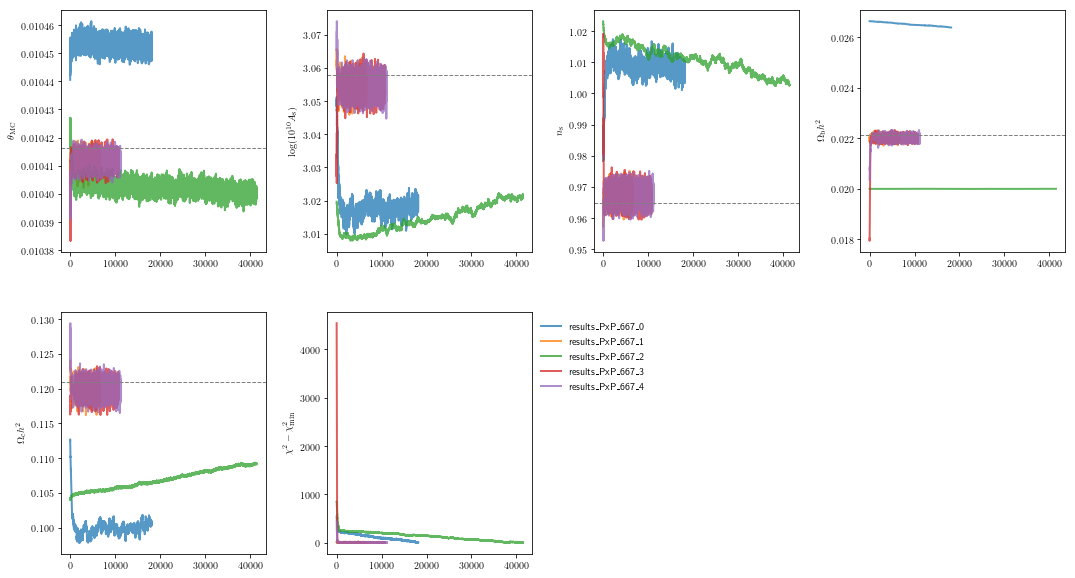

In [1]:
plot_chains(result_path + "/*_PxP_*/mcmc*.txt", burnin=0)

#### SOxSO - PxP



# Out[619]:

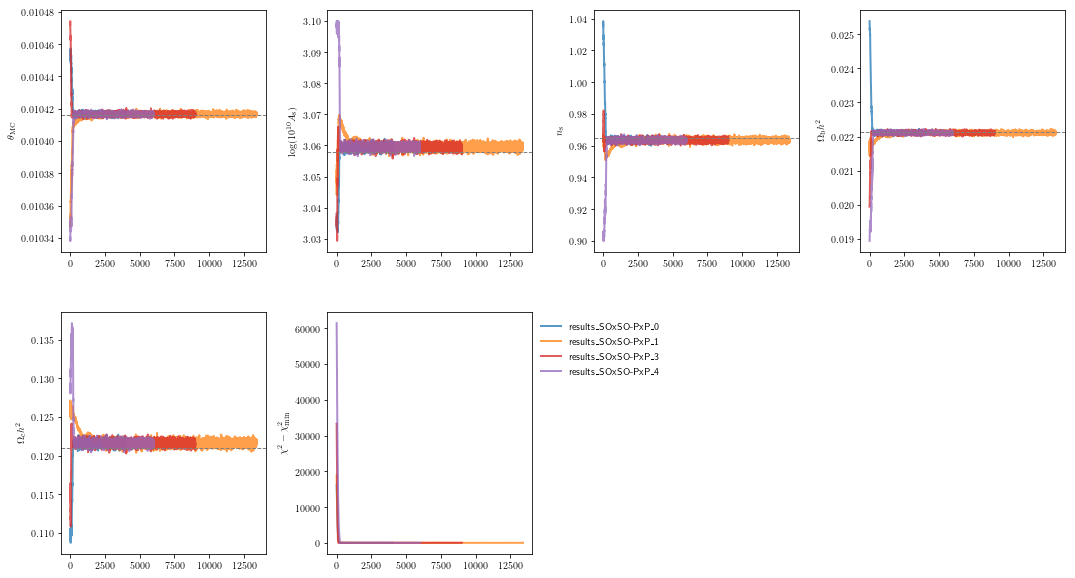

In [1]:
plot_chains(result_path + "/*_SOxSO-PxP_*/mcmc*.txt", burnin=0)

#### SOxP - PxP



# Out[862]:

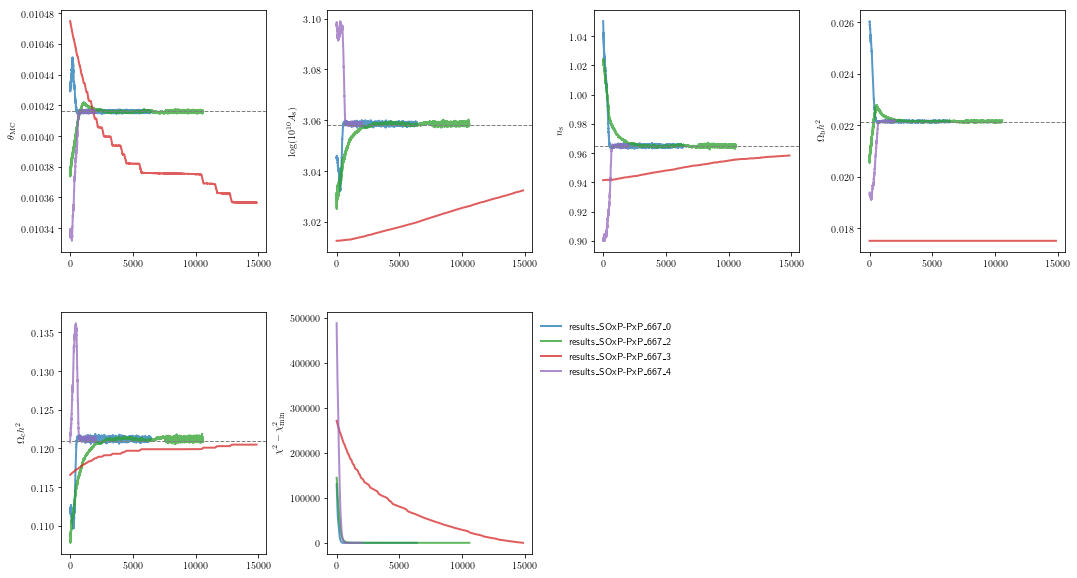

In [1]:
plot_chains(result_path + "/*_SOxP-PxP*/mcmc*.txt", burnin=0)

#### SOxP - SOxSO



# Out[633]:

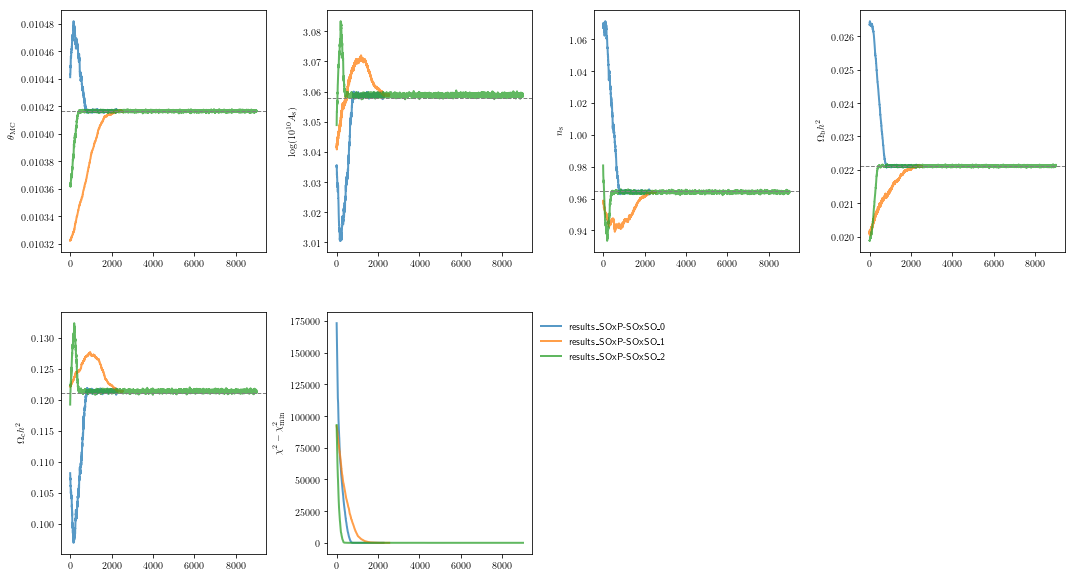

In [1]:
plot_chains(result_path + "/*_SOxP-SOxSO*/mcmc*.txt", burnin=0)

### Triangle plot



In [1]:
def get_samples(path):
    chains = get_chains(path)
    key = next(iter(chains))
    samples = chains[key].iloc[:, 1:].values
    weights = chains[key].iloc[:, 0].values
    return samples, weights

# Out[864]:

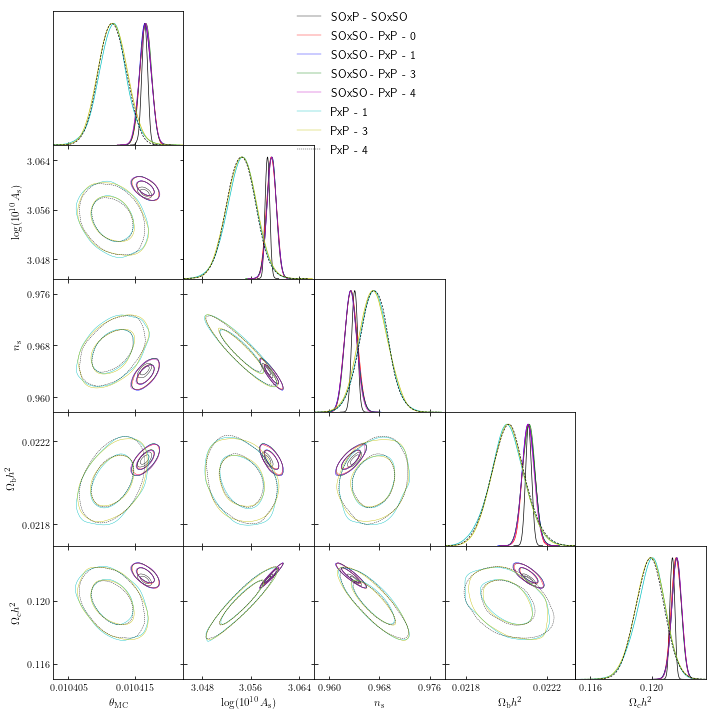

In [1]:
samples = []
s, w = get_samples(result_path + "/*_SOxP-SOxSO*2/mcmc*.txt")
samples += [MCSamples(samples=s, names=labels, label="SOxP - SOxSO", weights=w, ignore_rows=0.3)]

for i in [0, 1, 3, 4]:
    s, w = get_samples(result_path + "/*_SOxSO-PxP*{}/mcmc*.txt".format(i))
    samples += [MCSamples(samples=s, names=labels, label="SOxSO - PxP - {}".format(i), weights=w, ignore_rows=0.3)]
for i in [1, 3, 4]:
    s, w = get_samples(result_path + "/*_PxP*{}/mcmc*.txt".format(i))
    samples += [MCSamples(samples=s, names=labels, label="PxP - {}".format(i), weights=w, ignore_rows=0.3)]

g = plots.getSubplotPlotter()
g.triangle_plot(samples, params=labels[:-2])

### Plot variances from MCMC and Hessian



#### Compute standard deviation from MCMC



In [1]:
def get_mcmc_variances(path, burnin=0.3, keep_As=False):
    table = []
    lines = []
    all_files = glob.glob(path)
    all_files.sort()
    for f in all_files:
        samples, weights = get_samples(f)
        mcsamples = MCSamples(samples=samples, weights=weights, ignore_rows=burnin)
        sigmas = np.sqrt(mcsamples.getVars()).tolist()
        if keep_As:
            del sigmas[-2]
            table += [sigmas]
        else:
            table += [sigmas[:-2]]
        lines += [[f.split("/")[-2]]]
    table = np.append(lines, table, axis=1)
    return table

In [1]:
table = get_mcmc_variances(result_path + "/results*/mcmc*.txt")
display(HTML(tabulate.tabulate(table, headers=labels[:-2], tablefmt="html")))

##### Compare MCMC to minimization for PxP



# Out[855]:

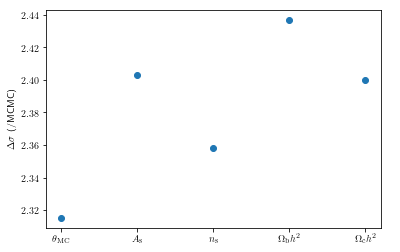

In [1]:
mcmc = get_mcmc_variances(result_path + "/results*_PxP_*[1,3,4]/mcmc*.txt", keep_As=True)
mcmc = np.mean(np.array(mcmc[:, 1:], dtype=np.float), axis=0)
mcmc[1] = mcmc[-1] # Use As for comparison
plt.plot(ref_std[:-1]/mcmc[:-1], "o")
plt.ylabel(r"$\Delta\sigma$ (/MCMC)")
xlabels = [r"$\theta_\mathrm{MC}$",
          r"$A_\mathrm{s}$",
          r"$n_\mathrm{s}$",
          r"$\Omega_\mathrm{b}h^2$",
          r"$\Omega_\mathrm{c}h^2$"]
plt.xticks(np.arange(len(xlabels)), xlabels)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

#### From Hessian



In [1]:
import pickle
def get_hessians(f):
    d = pickle.load(open(f, "rb"))
    # except:
    #     print("Fail to open {}".format(f))
    #     pass
    hess = d["results"]["OptimizeResult"]["hess_inv"]
    return np.sqrt(np.diagonal(hess))

def get_hessians_table(path):
    table = []
    lines = []
    files = glob.glob(path)
    files.sort()
    for f in files:
        table += [get_hessians(f).tolist()]
        lines += [[f.split("/")[-2]]]

    table = np.append(lines, table, axis=1)
    return table

In [1]:
table = get_hessians_table(result_path + "/output*/min*.pkl")
display(HTML(tabulate.tabulate(table, headers=labels[:-2], tablefmt="html")))

#### Summary



##### SOxSO - PxP



| |$\theta_\mathrm{MC}$|$A_\mathrm{s}$|$n_\mathrm{s}$|$\Omega_\mathrm{b}h^2$|$\Omega_\mathrm{c}h^2$|
|---|---|---|---|---|---|
| MCMC PxP|2.11021100e-06|5.09354804e-12|2.24682572e-03|8.37362917e-05|9.32820498e-04|
| MCMC (n° 0)|8.42204e-07|1.69715e-12|0.000987998|2.94139e-05|0.00032552|
| Min. ($\ell\in[2;3000]$)|3.76192e-06|9.58206e-12|0.00406034|0.000171957|0.00181588|
| Min. ($\ell\in[50;2000]$)|2.99731e-06|7.16794e-12|0.00314853|0.000122405|0.00133315|
| Min. ($\ell\in[50;1500]$)|1.8413e-06|4.23132e-12|0.0021341|7.39349e-05|0.000775937|



##### SOxP - SOxSO



| |$\theta_\mathrm{MC}$|$A_\mathrm{s}$|$n_\mathrm{s}$|$\Omega_\mathrm{b}h^2$|$\Omega_\mathrm{c}h^2$|
|---|---|---|---|---|---|
| MCMC (n° 2)|4.37106e-07|7.95761e-13|0.00046037|1.4894e-05|0.000152093|
| Min. ($\ell\in[2;3000]$)|2.53148e-06|7.13821e-12|0.00291831|0.000104709|0.00135525|
| Min. ($\ell\in[50;2000]$)|2.03202e-06|5.97189e-12|0.00261404|8.41646e-05|0.00127252|
| Min. ($\ell\in[50;1500]$)|9.88702e-07|2.64955e-12|0.00126386|4.27381e-05|0.000495158|



##### Plotting everything



# Out[858]:

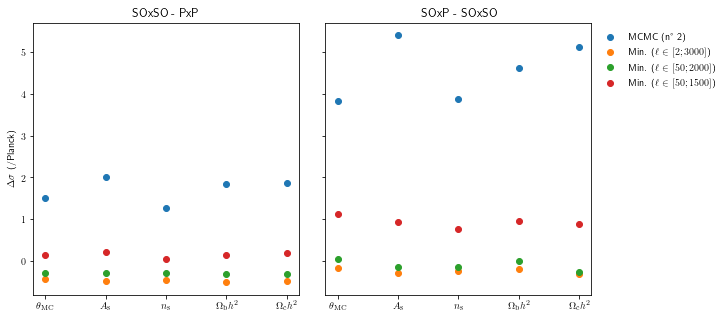

In [1]:
ref_std = np.array(data1[0][1:], dtype=np.float)
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 5))
xlabels = [r"$\theta_\mathrm{MC}$",
          r"$A_\mathrm{s}$",
          r"$n_\mathrm{s}$",
          r"$\Omega_\mathrm{b}h^2$",
          r"$\Omega_\mathrm{c}h^2$"]
x = np.arange(5)
for i in range(1, len(data1)):
    values = np.array(data1[i][1:], dtype=np.float)
    ax[0].plot(x, ref_std/values-1, "o")
ax[0].set_ylabel(r"$\Delta\sigma$ (/Planck)")
ax[0].set_title("SOxSO - PxP")
ax[0].set_xticks(x)
ax[0].set_xticklabels(xlabels)

for i in range(0, len(data2)):
    values = np.array(data2[i][1:], dtype=np.float)
    ax[1].plot(x, ref_std/values-1, "o", label=data2[i][0])

ax[1].set_title("SOxP - SOxSO")
ax[1].set_xticks(x)
ax[1].set_xticklabels(xlabels)
ax[1].legend(loc="upper left", bbox_to_anchor=(1,1))
plt.subplots_adjust(wspace=0.1)

### ALens



In [1]:
labels = [r"$\theta_\mathrm{MC}$",
          r"$\log(10^{10}A_\mathrm{s})$",
          r"$n_\mathrm{s}$",
          r"$\Omega_\mathrm{b}h^2$",
          r"$\Omega_\mathrm{c}h^2$",
          r"$\mathrm{A}_\mathrm{L}$",
          r"$\chi^2-\chi^2_\mathrm{min}$",
          r"$A_\mathrm{s}$"]

result_path = r"/home/garrido/Workdir/CMB/analysis/beyondCV/output/ALens"

#### Check minimization



Get Hessians from minimizations



In [1]:
def check_minimization(path):
    all_files = glob.glob(path)
    all_files.sort()
    table = []
    for f in all_files:
        import pickle
        opt_result =  pickle.load(open(f, "rb"))["results"]["OptimizeResult"]
        msg = opt_result.get("message")
        ntry = opt_result.get("ntry")
        proposal = np.sqrt(np.diag(opt_result.get("hess_inv")))
        table += [[f.split("/")[-2], msg, ntry, *proposal]]
    return table

headers = ["" for i in range(len(table))]
headers[0:3] = ["Directory", "Status", "ntry"]
table = check_minimization(result_path + "/results_*/min*.pkl")
print(tabulate.tabulate(table, headers=headers, tablefmt="orgtbl"))

| Directory                | Status                                                        | ntry |             |             |             |             |             |            |
|--------------------------+---------------------------------------------------------------+------+-------------+-------------+-------------+-------------+-------------+------------|
| results_PxP_666_0        | Optimization terminated successfully.                         |    1 | 2.45279e-06 |  0.00127271 |  0.00173696 | 1.92859e-05 | 0.000102676 |  0.0371089 |
| results_PxP_666_1        | Optimization terminated successfully.                         |    3 | 2.51867e-06 |  0.00127433 |  0.00174105 | 1.98167e-05 | 0.000104576 |  0.0372196 |
| results_PxP_666_2        | Optimization failed. Estimated distance to minimum too large. |   10 | 7.88674e-06 |   0.0054606 |  0.00336989 | 0.000469289 |  0.00161214 |  0.0321427 |
| results_PxP_666_3        | Optimization terminated successfully.                   

#### Check chains



##### PxP



# Out[601]:

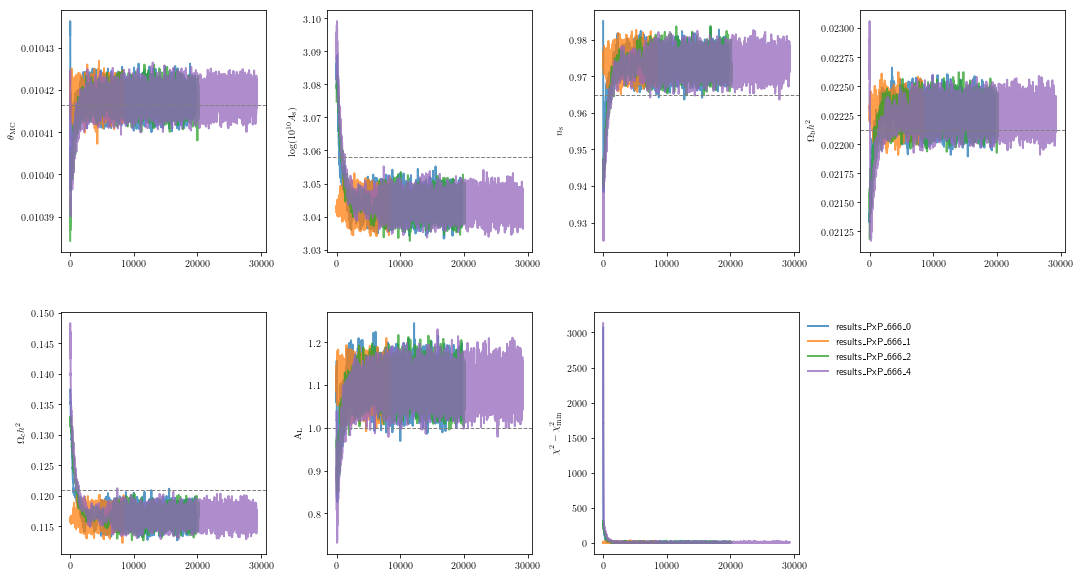

In [1]:
plot_chains(result_path + "/*_PxP*/mcmc*.txt", labels=labels)

##### SOxSO - PxP



# Out[602]:

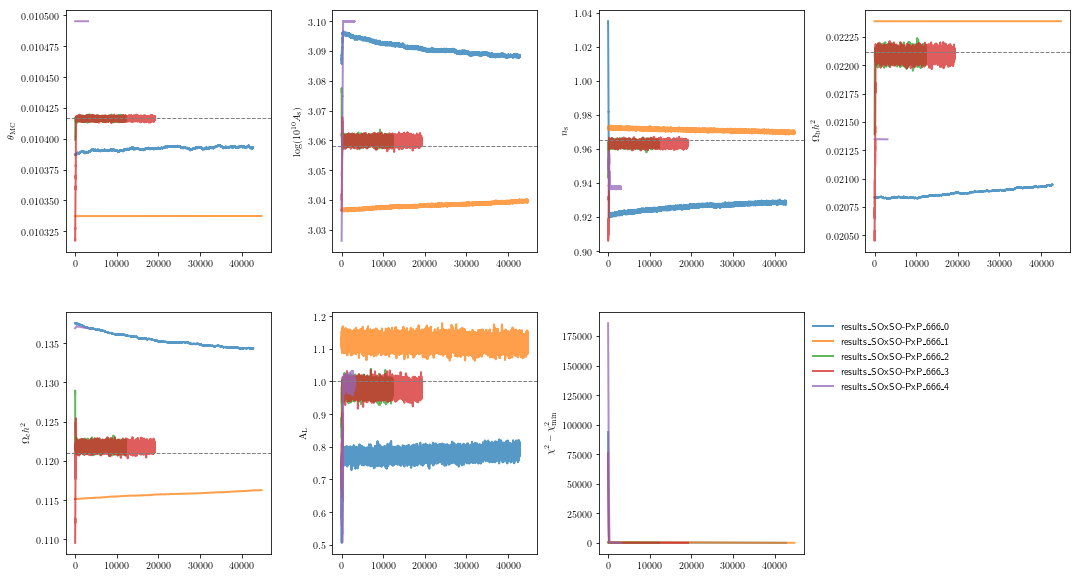

In [1]:
plot_chains(result_path + "/*_SOxSO-PxP*/mcmc*.txt", labels=labels)

##### SOxP - PxP



# Out[603]:

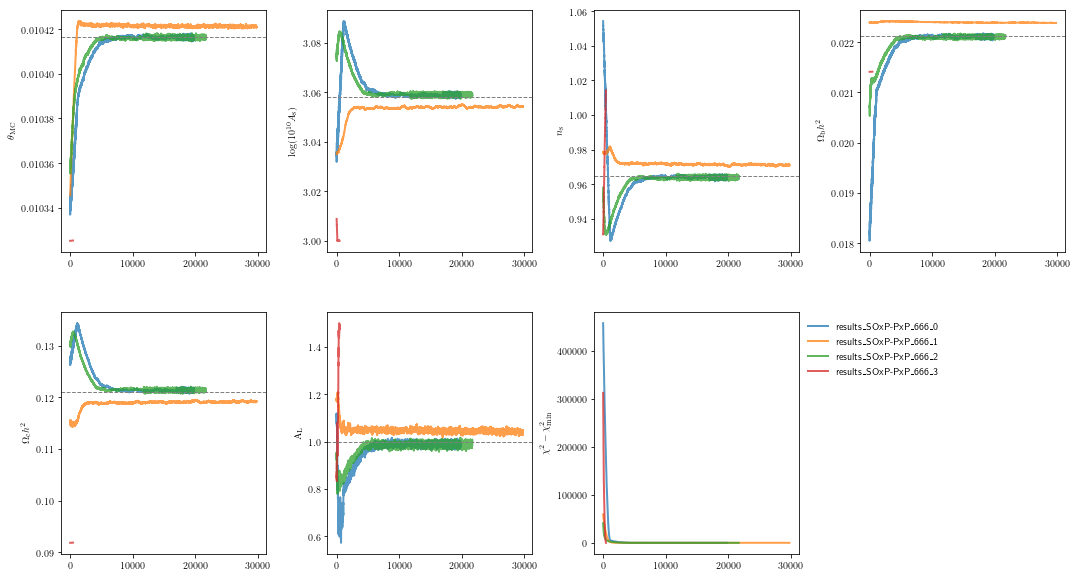

In [1]:
plot_chains(result_path + "/*_SOxP-PxP*/mcmc*.txt", burnin=0, labels=labels)

##### SOxP - SOxSO



# Out[604]:

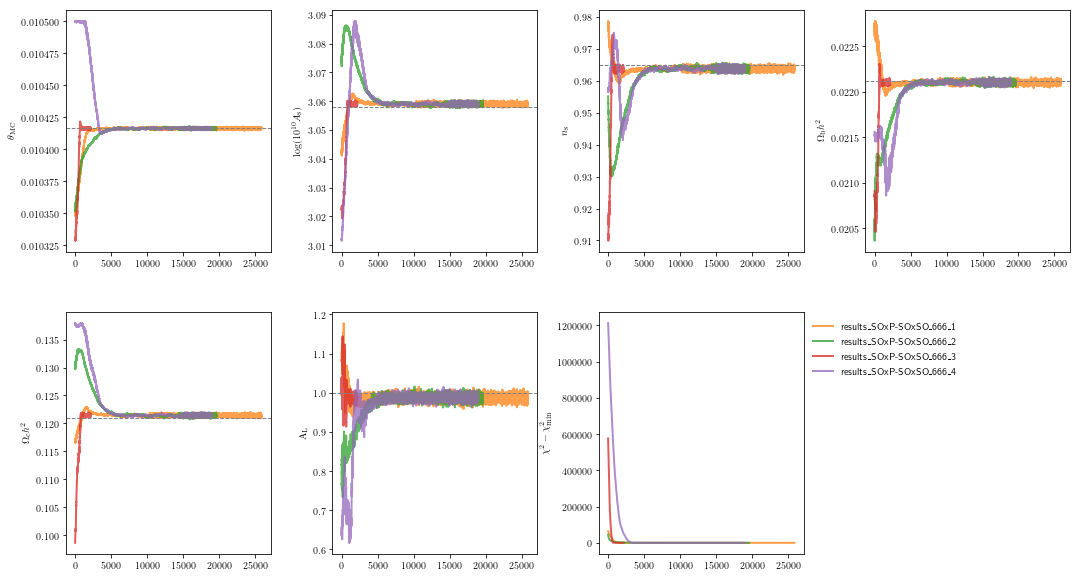

In [1]:
plot_chains(result_path + "/*_SOxP-SOxSO*/mcmc*.txt", labels=labels)

#### Triangle plot



In [1]:
def plot_samples(path, burnin=0.3):
    samples = []
    colors = []
    all_files = glob.glob(path)
    all_files.sort()
    for f in all_files:
        s, w = get_samples(f)
        survey = f.split("/")[-2]
        i = survey.split("_")[-1]
        survey = survey.split("_")[1]
        samples += [MCSamples(samples=s, names=labels, label="{} - MCMC {}".format(survey, i), weights=w, ignore_rows=burnin)]
        colors += [i]

    g = plots.getSubplotPlotter()
    g.settings.lineM = ["-C{}".format(i) for i in colors]
    g.triangle_plot(samples, params=labels[:-2])

##### PxP



# Out[605]:

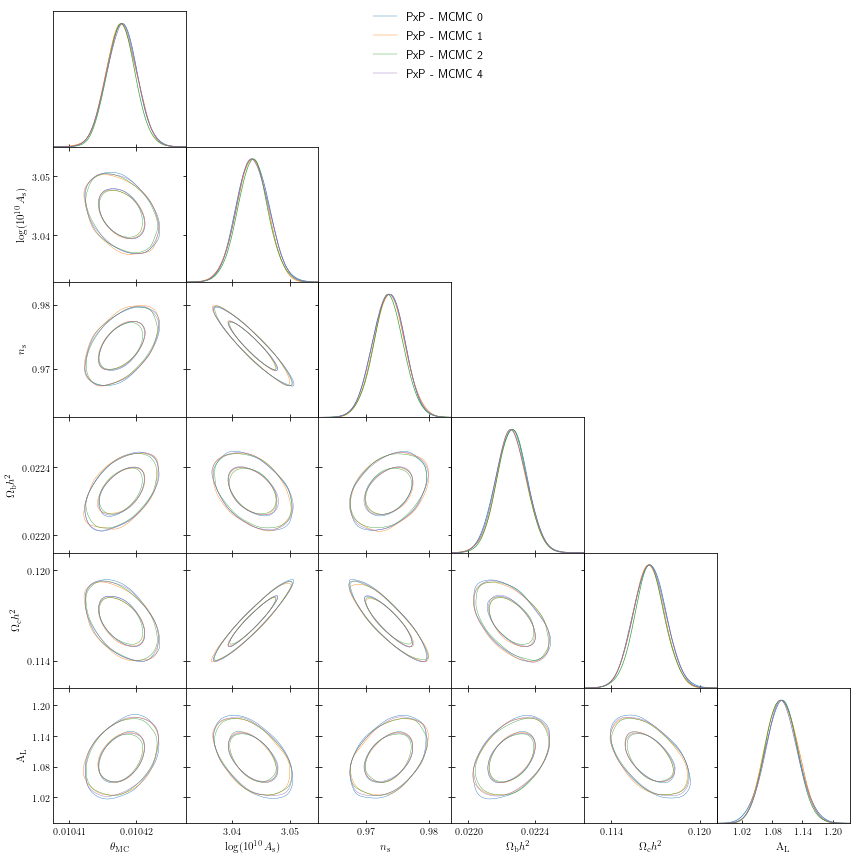

In [1]:
plot_samples(result_path + "/*_PxP*_[0-4]/mcmc*.txt", burnin=0.3)

##### SOxSO - PxP



# Out[606]:

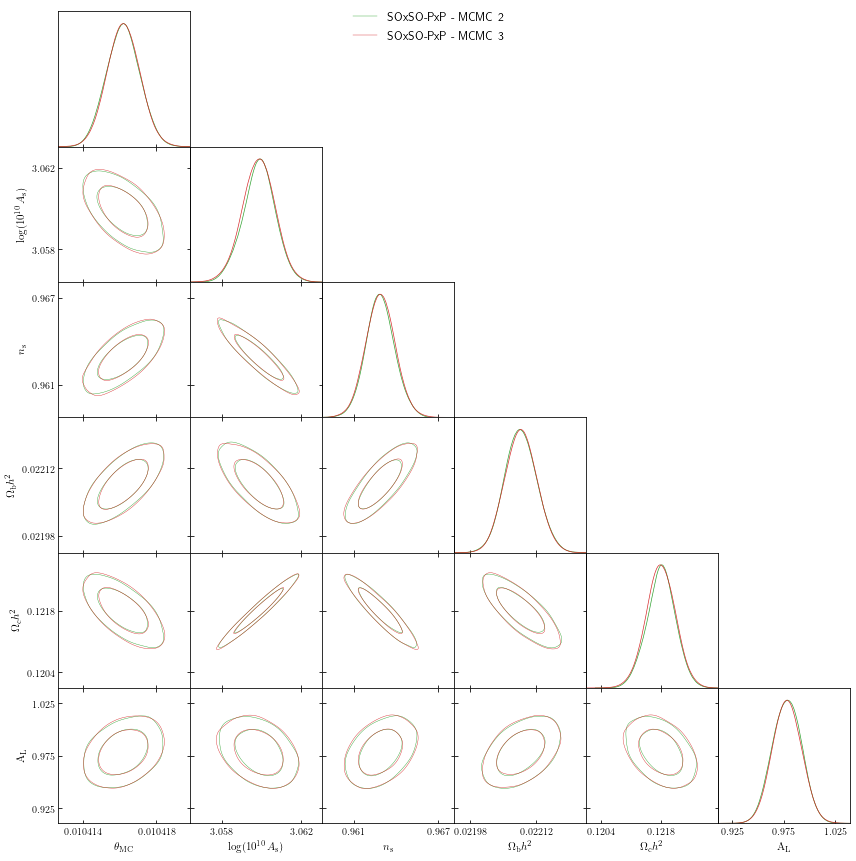

In [1]:
plot_samples(result_path + "/*_SOxSO-PxP*_[2,3]/mcmc*.txt", burnin=0.3)

##### SOxP - PxP



# Out[607]:

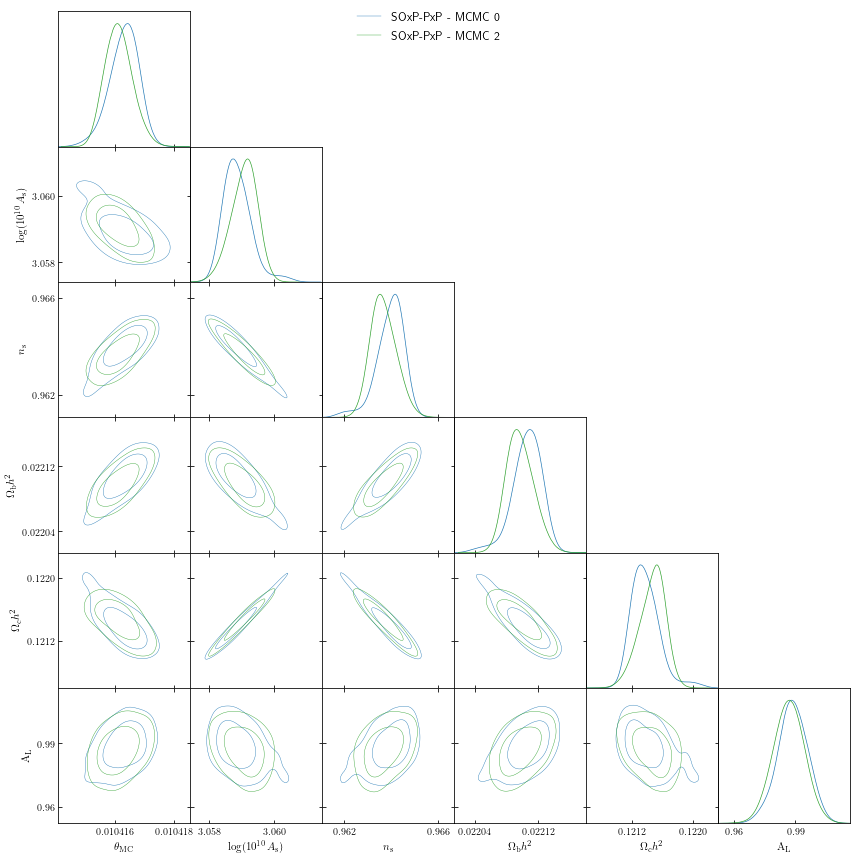

In [1]:
plot_samples(result_path + "/*_SOxP-PxP*_[0,2]/mcmc*.txt", burnin=0.3)

##### SOxP - SOxSO



# Out[608]:

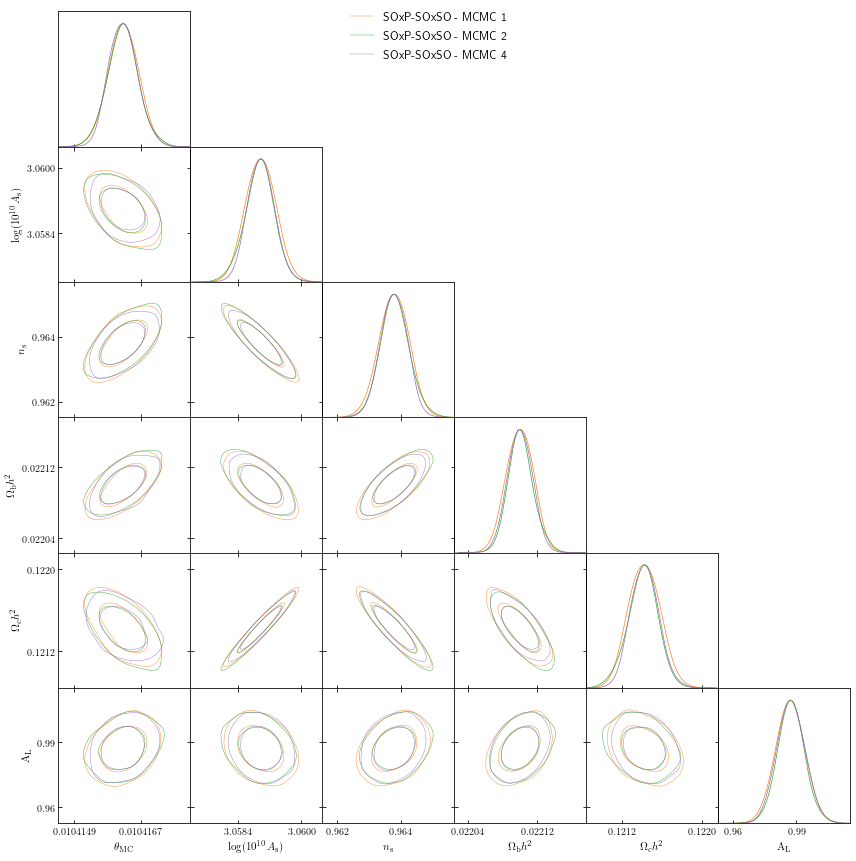

In [1]:
plot_samples(result_path + "/*_SOxP-SOxSO*_[1,2,4]/mcmc*.txt", burnin=0.3)

#### Compute standard deviation from MCMC



In [1]:
tablePP = get_mcmc_variances(result_path + "/*_PxP_*/mcmc*.txt", burnin=0.3)
tableSSPP = get_mcmc_variances(result_path + "/*_SOxSO-PxP_*[2,3]/mcmc*.txt", burnin=0.3)
tableSPSS = get_mcmc_variances(result_path + "/*_SOxP-SOxSO_*[1,2,4]/mcmc*.txt", burnin=0.3)

##### PxP



In [1]:
print(tabulate.tabulate(tablePP, headers=labels[:-2], tablefmt="orgtbl"))

|                   | $\theta_\mathrm{MC}$ | $\log(10^{10}A_\mathrm{s})$ | $n_\mathrm{s}$ | $\Omega_\mathrm{b}h^2$ | $\Omega_\mathrm{c}h^2$ | $\mathrm{A}_\mathrm{L}$ |
|-------------------+----------------------+-----------------------------+----------------+------------------------+------------------------+-------------------------|
| results_PxP_666_0 |          2.25445e-06 |                  0.00280028 |     0.00252237 |            9.44371e-05 |              0.0011046 |               0.0330274 |
| results_PxP_666_1 |           2.2771e-06 |                  0.00271089 |     0.00251489 |            9.19644e-05 |             0.00106107 |               0.0314946 |
| results_PxP_666_2 |          2.13857e-06 |                  0.00266458 |     0.00245774 |            8.94339e-05 |             0.00103877 |               0.0306628 |
| results_PxP_666_4 |          2.25782e-06 |                  0.00277658 |     0.00253481 |            9.34218e-05 |             0.00109458 |               0.03

##### SOxSO-PxP



In [1]:
print(tabulate.tabulate(tableSSPP, headers=labels[:-2], tablefmt="orgtbl"))

|                         | $\theta_\mathrm{MC}$ | $\log(10^{10}A_\mathrm{s})$ | $n_\mathrm{s}$ | $\Omega_\mathrm{b}h^2$ | $\Omega_\mathrm{c}h^2$ | $\mathrm{A}_\mathrm{L}$ |
|-------------------------+----------------------+-----------------------------+----------------+------------------------+------------------------+-------------------------|
| results_SOxSO-PxP_666_2 |          9.05033e-07 |                 0.000803214 |     0.00102366 |             3.4062e-05 |            0.000335125 |               0.0141448 |
| results_SOxSO-PxP_666_3 |          8.97457e-07 |                 0.000829307 |     0.00105136 |             3.3716e-05 |            0.000346686 |               0.0141123 |

##### SOxP-SOxSO



In [1]:
print(tabulate.tabulate(tableSPSS, headers=labels[:-2], tablefmt="orgtbl"))

|                          | $\theta_\mathrm{MC}$ | $\log(10^{10}A_\mathrm{s})$ | $n_\mathrm{s}$ | $\Omega_\mathrm{b}h^2$ | $\Omega_\mathrm{c}h^2$ | $\mathrm{A}_\mathrm{L}$ |
|--------------------------+----------------------+-----------------------------+----------------+------------------------+------------------------+-------------------------|
| results_SOxP-SOxSO_666_1 |          4.14193e-07 |                 0.000383167 |    0.000473693 |            1.57655e-05 |            0.000158367 |              0.00695751 |
| results_SOxP-SOxSO_666_2 |           4.1753e-07 |                 0.000364523 |    0.000451245 |            1.45673e-05 |            0.000149416 |              0.00647078 |
| results_SOxP-SOxSO_666_4 |          3.86853e-07 |                 0.000339615 |    0.000422059 |             1.4264e-05 |            0.000139798 |              0.00667364 |

##### Plot everything together



First check MCMC *vs.* Hessian



# Out[757]:

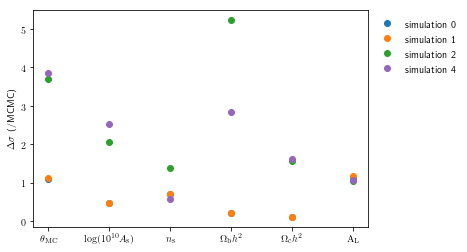

In [1]:
hessians = check_minimization(result_path + "/*_PxP_*[0,1,2,4]/min*.pkl")
hessians = np.array(hessians[:, 3:], dtype=np.float)
mcmc = np.array(tablePP[:, 1:], dtype=np.float)
for i in range(np.size(tablePP, 0)):
    label = tablePP[i, 0].split("_")[-1]
    plt.plot(hessians[i,]/mcmc[i,], "o", label="simulation {}".format(label), color="C{}".format(label))
plt.ylabel(r"$\Delta\sigma$ (/MCMC)")
xlabels = labels[:-2]
plt.xticks(np.arange(len(xlabels)), xlabels)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

# Out[756]:

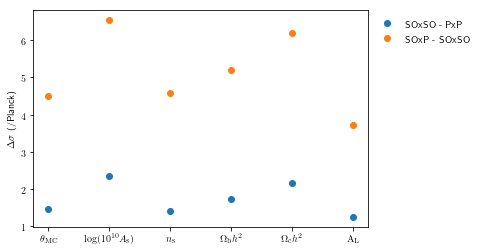

In [1]:
data = {"PP": pp, "SOxSO - PxP": sspp, "SOxP - SOxSO": spss}
sigmas = {}
for k, v in data.items():
    v = list(zip(*v))
    v = np.array(v[1:], dtype=np.float)
    sigmas[k] = np.mean(v, axis=1)
xlabels = labels[:-2]
x = np.arange(len(xlabels))
for k, v in sigmas.items():
    if k == "PP":
      continue
    plt.plot(x, sigmas["PP"]/v-1, "o", label=k)
plt.ylabel(r"$\Delta\sigma$ (/Planck)")
plt.xticks(x, labels[:-2])
plt.legend(loc="upper left", bbox_to_anchor=(1,1))